In [36]:
# import all libraries that will be used in this notebook
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
import regex as re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier, RandomForestClassifier, ExtraTreesClassifier
import time
import warnings
from sklearn.naive_bayes import MultinomialNB
#!pip install pactools
#warnings.filterwarnings('ignore')
from nltk.corpus import stopwords

%matplotlib inline
import matplotlib.pyplot as plt

from pactools.grid_search import GridSearchCVProgressBar

# 1. Import the data 

In [37]:
dat = pd.read_csv('./data/clean_data.csv')
dat.drop(columns = 'Unnamed: 0', inplace = True)

In [39]:
dat.head()

,post,label
0,welcome r depression check post place take mom...,0
1,instead called work breaking shift cry drive w...,0
2,stay alive witness,0
3,behaviour going anymore getting things done wo...,0
4,weeks ago ready end working decided visit cam ...,0


In [40]:
dat.tail()

,post,label
1463,anxiety bad long time one simple reason im hol...,1
1464,hysterectomy due fibroids although gotten clea...,1
1465,long story short started counseling last year ...,1
1466,hi guys girls hope well quick summary life suf...,1
1467,sooo exhausted f always edge reason poor boyfr...,1


In [41]:
dat.dropna(axis = 0, inplace = True)
dat.isnull().sum()

post     0
label    0
dtype: int64

In [50]:
dat['label'].value_counts()

0    749
1    718
Name: label, dtype: int64

# 2. Define X, y and apply train_test_split

In [46]:
X = list(dat['post'])
y = dat['label']
print(len(X))
print(y.shape)

1467
(1467,)


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [48]:
y_train.value_counts()

0    562
1    538
Name: label, dtype: int64

In [225]:
y_test.value_counts()

0    187
1    180
Name: label, dtype: int64

# 3. Establish the baseline accuracy

For a classification problem, the baseline accuracy is computed with the percentage of the majority class. This means that if we had a null model without any predictive power, it would always be predicting the majority class.

In [54]:
dat['label'].value_counts(normalize = True)

0    0.510566
1    0.489434
Name: label, dtype: float64

So our baseline accuracy score is 51%. If we were to ask a null model to make predictions on our data, the model would be correct in its predictions 51% of the time.

# 4. Customize stop_words

Here I add some words to the standard english stopwords to pass this custom list of stop words as another parameter into a grid search. I want to pass this as a parameter to ensure that we are grid searching on a model that excudes words such as **depression**, **anxiety** and derivative words thereof from its feature space. The reason I want to remove these words is because they are the key words that basically define the classes that I want to predict. I'm curious to see how the model performs with the otpions of not having these words in its feature space. 

In [68]:
stop_words_custom = stopwords.words("english") + ['depression', 'depressive', 'depressed', 'anxiety', 'anxious']

# 5. Create a function that builds a model, tunes hyperparameters and evaluates the model

To avoid redeundancy in large blocks of code, I have created a function that creates a pipeline for model building, does hyperparameter tuning with gridsearch and outputs a variety of evaluation metrics for the best model. This function takes in as arguments our train and test data, a vectorizer transformer (tfidf or count vectorizer) and a classification model for its pipeline, and a dictionary of hyperparameters to do a grid search over. 

In [69]:
def pipe_gs(X_train, X_test, y_train, y_test, vec, pipe_params):
    
    # build a pipeline 
    pipe = Pipeline([
        ('vec', vec), # pass a vectorizer to the pipeline 
        ('clf', clf)  # pass a classification model to the pipeline 
    ])
    
    # set a dictionary of parameters to tune over
    pipe_params 
    
    # do a grid search over the parameters specified in pipe_params and then do a 3-fold cross valiation
    gs = GridSearchCVProgressBar(pipe, param_grid=pipe_params, cv=3, verbose = 1, n_jobs = 4)
    gs.fit(X_train, y_train)
    print('')
    print('')
    
    # best parameters 
    print('best paramteres: '+str(gs.best_params_))
    print('')
    print('')
   
    # cross_val score 
    cv_score = gs.best_score_
  
    # training score 
    train_score = gs.score(X_train, y_train)
   
    # testing score 
    test_score = gs.score(X_test, y_test)
   
    # predictions of the best model 
    y_pred = gs.predict(X_test)
    
    # accuracy score 
    accuracy = accuracy_score(y_test, y_pred)

    # print('confusion matrix: '+str(confusion_matrix(y_test,y_pred)))
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    
    # sensitivity
    sensitivity = tp / (tp + fn)
    
    # specificity 
    specificity = tn / (tn + fp)
    
    # precision 
    precision = tp / (tp + fp)
    
    # misclassification
    misclass = 1 - accuracy 
    
    # predicted pprobabilites of the best model
    y_pred_prob = gs.predict_proba(X_test)[:,1] 
    
    # auc score 
    auc = roc_auc_score(y_test, y_pred_prob)
    
    # plot the ROC curve 
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    metric_names =  ['cross val score', 
                     'train score', 
                     'test score', 
                     'accuracy', 
                     'misclassification', 
                     'true positives', 
                     'true negatives', 
                     'false positives', 
                     'false negatives', 
                     'sensitivity (tpr)', 
                     'specificity (tnr)',
                     'precision (ppv)']
    
    metrics = [cv_score, 
               train_score, 
               test_score, 
               accuracy, 
               misclass, 
               tp, 
               tn, 
               fp, 
               fn, 
               sensitivity, 
               specificity, 
               precision]
    
    d = {'metric':metric_names, 
         'value': metrics}
   
    df = pd.DataFrame(d)
      
    return df

I will demonstrate using this function in the case of logistic regression to show the type of output the function creates. I will then provide the code for calling the function for a variety of other models with their specific parameters. However, I will not actually run the code in the case of every remaining model in this notebook due to 1. computational expense, 2.time it will take to run the gridsearch over every single model and 3. the clutter that will be created as a result of pupulating this notebook with the outputs. I have of course done this previously and saved the output of every model in a separate file. The results are shown graphically and are discussed in notebook **4. Model Evaluation and Final Model Selection**. 

# 6. Building and Evaluating Models 

## 6.1. Logistic Regression

### 6.1.1. Logistic Regression pipeline with count vectorizer with default parameters - no GridSearch

In [71]:
pipe = Pipeline([
    ('vec', CountVectorizer(stop_words = 'english')),
    ('lr', LogisticRegression())
])

# Evaluate how your model will perform on unseen data
print(cross_val_score(pipe, X_train, y_train, cv=3).mean())
# Fit your model
pipe.fit(X_train, y_train)
# Training score
print(pipe.score(X_train, y_train))
# Test score
print(pipe.score(X_test, y_test))

/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8299477310525066
0.9972727272727273
0.8147138964577657


### 6.1.1. Logistic Regression pipeline with count vectorizer and GridSaerch 

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   41.9s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  6.6min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed:  8.1min
[Parallel(n_jobs=4)]: Done 5184 out of 5184 | elapsed:  8.4min finished
/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/use



best paramteres: {'clf__C': 0.5, 'clf__penalty': 'l1', 'vec__max_df': 0.7, 'vec__max_features': 800, 'vec__min_df': 20, 'vec__ngram_range': (1, 2), 'vec__stop_words': 'english'}




,metric,value
0,cross val score,0.846364
1,train score,0.920000
2,test score,0.798365
3,accuracy,0.798365
4,misclassification,0.201635
5,true positives,129.000000
6,true negatives,164.000000
7,false positives,23.000000
8,false negatives,51.000000
9,sensitivity (tpr),0.716667


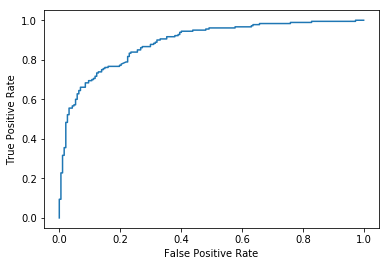

In [72]:
vec = CountVectorizer()
clf = LogisticRegression()

pipe_params = {'vec__max_features': [800, 1000, 1500],
 'vec__min_df': [10, 15, 20, 25],
 'vec__max_df': [.7, .8, .9, 1.0],
 'vec__ngram_range': [(1,1), (1,2),(1,3)],
 'vec__stop_words':['english', stop_words_custom],
 'clf__penalty':['l1', 'l2'],
 'clf__C':[0.1, 0.5, 0.99]}

pipe_gs(X_train, X_test, y_train, y_test, vec, pipe_params)

### 6.1.3. Logistic Regression pipeline with count tfidf vectorizer with default parameters - no GridSearch

In [74]:
pipe = Pipeline([
    ('vec', TfidfVectorizer(stop_words = 'english')),
    ('lr', LogisticRegression())
])

# Evaluate how your model will perform on unseen data
print(cross_val_score(pipe, X_train, y_train, cv=3).mean())
# Fit your model
pipe.fit(X_train, y_train)
# Training score
print(pipe.score(X_train, y_train))
# Test score
print(pipe.score(X_test, y_test))

/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8417973390354003
0.9709090909090909
0.8228882833787466


### 6.1.1. Logistic Regression pipeline with tfidf vectorizer and GridSaerch 

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   44.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed:  8.4min
[Parallel(n_jobs=4)]: Done 5184 out of 5184 | elapsed:  8.8min finished
/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/use



best paramteres: {'clf__C': 0.99, 'clf__penalty': 'l2', 'vec__max_df': 0.7, 'vec__max_features': 800, 'vec__min_df': 15, 'vec__ngram_range': (1, 1), 'vec__stop_words': 'english'}




,metric,value
0,cross val score,0.845455
1,train score,0.932727
2,test score,0.822888
3,accuracy,0.822888
4,misclassification,0.177112
5,true positives,135.000000
6,true negatives,167.000000
7,false positives,20.000000
8,false negatives,45.000000
9,sensitivity (tpr),0.750000


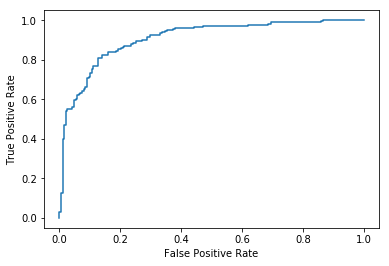

In [75]:
vec = TfidfVectorizer()
clf = LogisticRegression()

pipe_params = {'vec__max_features': [800, 1000, 1500],
 'vec__min_df': [10, 15, 20, 25],
 'vec__max_df': [.7, .8, .9, 1.0],
 'vec__ngram_range': [(1,1), (1,2),(1,3)],
 'vec__stop_words':['english', stop_words_custom],
 'clf__penalty':['l1', 'l2'],
 'clf__C':[0.1, 0.5, 0.99]}

pipe_gs(X_train, X_test, y_train, y_test, vec, pipe_params)

## 6.2. Naive Bayes 

### 6.2.1. Naive Bayes pipeline with count vectorizer with default parameters - no GridSearch

In [ ]:
pipe = Pipeline([
    ('vec', CountVectorizer(stop_words = 'english')),
    ('mnb', MultinomialNB())
])

# Evaluate how your model will perform on unseen data
print(cross_val_score(pipe, X_train, y_train, cv=3).mean())
# Fit your model
pipe.fit(X_train, y_train)
# Training score
print(pipe.score(X_train, y_train))
# Test score
print(pipe.score(X_test, y_test))

### 6.2.2. Naive Bayes pipeline with count vectorizer with GridSearch

In [ ]:
vec = CountVectorizer()
clf = MultinomialNB()

pipe_params = {
        'vec__max_features': [800, 1000, 1500],
        'vec__min_df': [10, 15, 20, 25],
        'vec__max_df': [.7, .8, .9, 1.0],
        'vec__ngram_range': [(1,1), (1,2),(1,3)],
        'vec__stop_words':['english', stop_words_mod],
        'clf__alpha':[0.0, 1.0]
    }

pipe_gs(X_train, X_test, y_train, y_test, vec, pipe_params)

### 6.2.3. Naive Bayes pipeline with tfidf vectorizer with default parameters - no GridSearch

In [ ]:
pipe = Pipeline([
    ('vec', TfidfVectorizer(stop_words = 'english')),
    ('mnb', MultinomialNB())
])

# Evaluate how your model will perform on unseen data
print(cross_val_score(pipe, X_train, y_train, cv=3).mean())
# Fit your model
pipe.fit(X_train, y_train)
# Training score
print(pipe.score(X_train, y_train))
# Test score
print(pipe.score(X_test, y_test))

### 6.2.4. Naive Bayes pipeline with tfidf vectorizer with GridSearch

In [ ]:
vec = TfidfVectorizer()
clf = MultinomialNB()

pipe_params = {
        'vec__max_features': [800, 1000, 1500],
        'vec__min_df': [10, 15, 20, 25],
        'vec__max_df': [.7, .8, .9, 1.0],
        'vec__ngram_range': [(1,1), (1,2),(1,3)],
        'vec__stop_words':['english', stop_words_mod],
        'clf__alpha':[0.0, 1.0]
    }

pipe_gs(X_train, X_test, y_train, y_test, vec, pipe_params)

## 6.3. K-Nearest Neighbors  

### 6.3.1. KNN pipeline with count vectorizer with default parameters - no GridSearch

In [ ]:
pipe = Pipeline([
    ('vec', CountVectorizer(stop_words = 'english')),
    ('knn', KNeighborsClassifier())
])

# Evaluate how your model will perform on unseen data
print(cross_val_score(pipe, X_train, y_train, cv=3).mean())
# Fit your model
pipe.fit(X_train, y_train)
# Training score
print(pipe.score(X_train, y_train))
# Test score
print(pipe.score(X_test, y_test))

### 6.3.2. KNN pipeline with count vectorizer with GridSearch

In [ ]:
vec = CountVectorizer()
clf = KNeighborsClassifier()

pipe_params = {
        'vec__max_features': [800, 1000, 1500],
        'vec__min_df': [10, 15, 20, 25],
        'vec__max_df': [.7, .8, .9, 1.0],
        'vec__ngram_range': [(1,1), (1,2),(1,3)],
        'vec__stop_words':['english', stop_words_mod],
        'clf__n_neighbors':[20, 30, 40, 50],
        'clf__weights':['uniform', 'distance'],
        'clf__p':[1, 2]
    }

pipe_gs(X_train, X_test, y_train, y_test, vec, pipe_params)

### 6.3.3. KNN pipeline with tfidf vectorizer with default parameters - no GridSearch

In [ ]:
pipe = Pipeline([
    ('vec', TfidfVectorizer(stop_words = 'english')),
    ('knn', KNeighborsClassifier())
])

# Evaluate how your model will perform on unseen data
print(cross_val_score(pipe, X_train, y_train, cv=3).mean())
# Fit your model
pipe.fit(X_train, y_train)
# Training score
print(pipe.score(X_train, y_train))
# Test score
print(pipe.score(X_test, y_test))

### 6.3.4. KNN pipeline with tfidf vectorizer with GridSearch

In [ ]:
vec = CountVectorizer()
clf = KNeighborsClassifier()

pipe_params = {
        'vec__max_features': [800, 1000, 1500],
        'vec__min_df': [10, 15, 20, 25],
        'vec__max_df': [.7, .8, .9, 1.0],
        'vec__ngram_range': [(1,1), (1,2),(1,3)],
        'vec__stop_words':['english', stop_words_mod],
        'clf__n_neighbors':[20, 30, 40, 50],
        'clf__weights':['uniform', 'distance'],
        'clf__p':[1, 2]
    }

pipe_gs(X_train, X_test, y_train, y_test, vec, pipe_params)

## 6.4. Decision Tree

### 6.4.1. Decision Tree pipeline with count vectorizer with default parameters - no GridSearch

In [ ]:
pipe = Pipeline([
    ('vec', CountVectorizer(stop_words = 'english')),
    ('dt', DecisionTreeClassifier())
])

# Evaluate how your model will perform on unseen data
print(cross_val_score(pipe, X_train, y_train, cv=3).mean())
# Fit your model
pipe.fit(X_train, y_train)
# Training score
print(pipe.score(X_train, y_train))
# Test score
print(pipe.score(X_test, y_test))

### 6.4.2. Decision Tree pipeline with count vectorizer with GridSearch

In [ ]:
vec = CountVectorizer()
clf = DecisionTreeClassifier()

pipe_params = {
        'vec__max_features': [800, 1000, 1500],
        'vec__min_df': [10, 15, 20, 25],
        'vec__max_df': [.7, .8, .9, 1.0],
        'vec__ngram_range': [(1,1), (1,2),(1,3)],
        'vec__stop_words':['english', stop_words_mod],
        'clf__max_depth':[2,3],
        'clf__min_samples_split':[2,5,10]
    }

pipe_gs(X_train, X_test, y_train, y_test, vec, pipe_params)

### 6.4.3. Decision Tree pipeline with tfidf vectorizer with default parameters - no GridSearch

In [ ]:
pipe = Pipeline([
    ('vec', TfidfVectorizer(stop_words = 'english')),
    ('dt', DecisionTreeClassifier())
])

# Evaluate how your model will perform on unseen data
print(cross_val_score(pipe, X_train, y_train, cv=3).mean())
# Fit your model
pipe.fit(X_train, y_train)
# Training score
print(pipe.score(X_train, y_train))
# Test score
print(pipe.score(X_test, y_test))

### 6.4.4. Decision Tree pipeline with tfidf vectorizer with GridSearch

In [ ]:
vec = TfidfVectorizer()
clf = DecisionTreeClassifier()

pipe_params = {
        'vec__max_features': [800, 1000, 1500],
        'vec__min_df': [10, 15, 20, 25],
        'vec__max_df': [.7, .8, .9, 1.0],
        'vec__ngram_range': [(1,1), (1,2),(1,3)],
        'vec__stop_words':['english', stop_words_mod],
        'clf__max_depth':[2,3],
        'clf__min_samples_split':[2,5,10]
    }

pipe_gs(X_train, X_test, y_train, y_test, vec, pipe_params)

## 6.5. Bagging 

### 6.5.1. Bagging pipeline with count vectorizer with default parameters - no GridSearch

In [ ]:
pipe = Pipeline([
    ('vec', CountVectorizer(stop_words = 'english')),
    ('bag', BaggingClassifier())
])

# Evaluate how your model will perform on unseen data
print(cross_val_score(pipe, X_train, y_train, cv=3).mean())
# Fit your model
pipe.fit(X_train, y_train)
# Training score
print(pipe.score(X_train, y_train))
# Test score
print(pipe.score(X_test, y_test))

### 6.5.2. Bagging pipeline with count vectorizer with GridSearch

In [ ]:
vec = CountVectorizer()
clf = BaggingClassifier()

pipe_params = {
        'vec__max_features': [800, 1000, 1500],
        'vec__min_df': [10, 15, 20, 25],
        'vec__max_df': [.7, .8, .9, 1.0],
        'vec__ngram_range': [(1,1), (1,2),(1,3)],
        'vec__stop_words':['english', stop_words_mod],
        'clf__n_estimators':[10, 20, 30]
    }

pipe_gs(X_train, X_test, y_train, y_test, vec, pipe_params)

### 6.5.3. Bagging pipeline with tfidf vectorizer with default parameters - no GridSearch

In [ ]:
pipe = Pipeline([
    ('vec', TfidfVectorizer(stop_words = 'english')),
    ('bag', BaggingClassifier())
])

# Evaluate how your model will perform on unseen data
print(cross_val_score(pipe, X_train, y_train, cv=3).mean())
# Fit your model
pipe.fit(X_train, y_train)
# Training score
print(pipe.score(X_train, y_train))
# Test score
print(pipe.score(X_test, y_test))

### 6.5.4. Bagging pipeline with tfidf vectorizer with GridSearch

In [ ]:
vec = CountVectorizer()
clf = BaggingClassifier()

pipe_params = {
        'vec__max_features': [800, 1000, 1500],
        'vec__min_df': [10, 15, 20, 25],
        'vec__max_df': [.7, .8, .9, 1.0],
        'vec__ngram_range': [(1,1), (1,2),(1,3)],
        'vec__stop_words':['english', stop_words_mod],
        'clf__n_estimators':[10, 20, 30]
    }

pipe_gs(X_train, X_test, y_train, y_test, vec, pipe_params)

## 6.6. Random Forest  

### 6.6.1. Random Forest pipeline with count vectorizer with default parameters - no GridSearch

In [ ]:
pipe = Pipeline([
    ('vec', CountVectorizer(stop_words = 'english')),
    ('rf', RandomForestClassifier())
])

# Evaluate how your model will perform on unseen data
print(cross_val_score(pipe, X_train, y_train, cv=3).mean())
# Fit your model
pipe.fit(X_train, y_train)
# Training score
print(pipe.score(X_train, y_train))
# Test score
print(pipe.score(X_test, y_test))

### 6.6.2. Random Forest pipeline with count vectorizer with GridSearch

In [ ]:
vec = CountVectorizer()
clf = RandomForestClassifier()

pipe_params = {
        'vec__max_features': [800, 1000, 1500],
        'vec__min_df': [10, 15, 20, 25],
        'vec__max_df': [.7, .8, .9, 1.0],
        'vec__ngram_range': [(1,1), (1,2),(1,3)],
        'vec__stop_words':['english', stop_words_mod],
        'clf__n_estimators':[10, 20, 30]
    }

pipe_gs(X_train, X_test, y_train, y_test, vec, pipe_params)

### 6.6.3. Random Forest pipeline with tfidf vectorizer with default parameters - no GridSearch

In [ ]:
pipe = Pipeline([
    ('vec', TfidfVectorizer(stop_words = 'english')),
    ('rf', RandomForestClassifier())
])

# Evaluate how your model will perform on unseen data
print(cross_val_score(pipe, X_train, y_train, cv=3).mean())
# Fit your model
pipe.fit(X_train, y_train)
# Training score
print(pipe.score(X_train, y_train))
# Test score
print(pipe.score(X_test, y_test))

### 6.6.4. Random Forest pipeline with tfidf vectorizer with GridSearch

In [ ]:
vec = TfidfVectorizer()
clf = RandomForestClassifier()

pipe_params = {
        'vec__max_features': [800, 1000, 1500],
        'vec__min_df': [10, 15, 20, 25],
        'vec__max_df': [.7, .8, .9, 1.0],
        'vec__ngram_range': [(1,1), (1,2),(1,3)],
        'vec__stop_words':['english', stop_words_mod],
        'clf__n_estimators':[10, 20, 30]
    }

pipe_gs(X_train, X_test, y_train, y_test, vec, pipe_params)

## 6.7. Extra Trees 

### 6.6.1. Extra Trees pipeline with count vectorizer with default parameters - no GridSearch

In [ ]:
pipe = Pipeline([
    ('vec', CountVectorizer(stop_words = 'english')),
    ('et', ExtraTreeClassifier())
])

# Evaluate how your model will perform on unseen data
print(cross_val_score(pipe, X_train, y_train, cv=3).mean())
# Fit your model
pipe.fit(X_train, y_train)
# Training score
print(pipe.score(X_train, y_train))
# Test score
print(pipe.score(X_test, y_test))

### 6.6.2. Extra Trees pipeline with count vectorizer with GridSearch

In [ ]:
vec = CountVectorizer()
clf = ExtraTreesClassifier()

pipe_params = {
        'vec__max_features': [800, 1000, 1500],
        'vec__min_df': [10, 15, 20, 25],
        'vec__max_df': [.7, .8, .9, 1.0],
        'vec__ngram_range': [(1,1), (1,2),(1,3)],
        'vec__stop_words':['english', stop_words_mod],
        'clf__n_estimators':[10, 20, 30]
    }

pipe_gs(X_train, X_test, y_train, y_test, vec, pipe_params)

### 6.6.3. Extra Trees pipeline with tfidf vectorizer with default parameters - no GridSearch

In [ ]:
pipe = Pipeline([
    ('vec', TfidfVectorizer(stop_words = 'english')),
    ('et', ExtraTreeClassifier())
])

# Evaluate how your model will perform on unseen data
print(cross_val_score(pipe, X_train, y_train, cv=3).mean())
# Fit your model
pipe.fit(X_train, y_train)
# Training score
print(pipe.score(X_train, y_train))
# Test score
print(pipe.score(X_test, y_test))

### 6.6.4. Extra Trees pipeline with tfidf vectorizer with GridSearch

In [ ]:
vec = TfidfVectorizer()
clf = ExtraTreesClassifier()

pipe_params = {
        'vec__max_features': [800, 1000, 1500],
        'vec__min_df': [10, 15, 20, 25],
        'vec__max_df': [.7, .8, .9, 1.0],
        'vec__ngram_range': [(1,1), (1,2),(1,3)],
        'vec__stop_words':['english', stop_words_mod],
        'clf__n_estimators':[10, 20, 30]
    }

pipe_gs(X_train, X_test, y_train, y_test, vec, pipe_params)

# 7. Prepwork for Conclusive Insights 

In notebook **4. Model Evaluation and Final Model Selection**, I evaluate the models and choose the best model based on the two criteria I defined in notebook **1. Problem Statement and Getting Data**. However, it may be a good idea to do a more qualitative assessment of how weel the best model is performing on classifying between two subreddits by looking at its interpretability. The next three codeblocks will extract the most important features that the best model found. These features will be qualitatively assessed on how well or poorly they may fit within the generalized definition of depression disorder and anxiety disorder. A more thorough discussion on this can be found in notebook **5.Conclusive Insights and Recommendations**  

In [ ]:
# build a pipeline with the best model (naive bayes), tfidf vectorizer and the best parameters
vec = TfidfVectorizer()

pipe_params = {
        'vec__max_features': [800],
        'vec__min_df': [20],
        'vec__max_df': [.7],
        'vec__ngram_range': [(1,1)],
        'vec__stop_words':['english'],
        'mnb__alpha':[1.0]
    }

# run the pipelin in GridSearch
gs = GridSearchCVProgressBar(pipe, param_grid=pipe_params, cv=3, verbose = 1, n_jobs = 4)
gs.fit(X_train, y_train)

# save the coefficients of the best model into a list
coef_array = gs.best_estimator_.named_steps['mnb'].coef_
coef_array.tolist()[0]

In [427]:
# create a data frame that aligns feature names with the coefficient of the feature
important_features = pd.DataFrame(zip(df.columns, coef_array.tolist()[0]), columns = ['feature', 'importance'])

In [448]:
important_features.sort_values(by = 'importance')

,feature,importance
274,kill,-8.496909
411,rant,-8.496909
8,alive,-8.314587
432,sadness,-8.314587
336,miserable,-8.314587
222,happiness,-8.314587
93,cried,-8.160437
107,dead,-8.160437
458,sister,-8.160437
206,grades,-8.160437
